### Initial Imports and Setup

- `numpy`: A fundamental package for scientific computing with Python. It's used for handling arrays and mathematical operations.
- `matplotlib.pyplot`: A plotting library that we'll use to visualize data and results in a graphical format.
- `pandas`: An open-source library providing high-performance, easy-to-use data structures, and data analysis tools.
- `MetaTrader5` (mt5): A library to integrate Python with MetaTrader 5 for accessing financial market data and trading operations.
- `datetime`: A module to work with dates and times, allowing us to handle time data types.
- `sklearn.preprocessing.StandardScaler`: A tool from the scikit-learn library to standardize features by removing the mean and scaling to unit variance.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import MetaTrader5 as mt5
from datetime import datetime
from sklearn.preprocessing import StandardScaler

### Setting Up Connection and Data Collection

This section initializes a connection with MetaTrader 5, crucial for accessing financial market data. It outlines the process of defining an analysis period and setting up the currency pairs for analysis.

#### Key Steps:
- **MetaTrader 5 Initialization**: Establishes a connection with the MetaTrader 5 terminal to access market data.
- **Analysis Period Definition**: Specifies the start and end dates for the data collection period.
- **Symbol Configuration**: Identifies `symbols` as the market symbol of interest.

#### Data Preparation:
- **Data Consolidation**: Historical data for each symbol is consolidated into a single DataFrame, with an emphasis on organizing and cleaning the data.
- **Standardization**: Applies standard scaling to the numerical columns (`open`, `high`, `low`, `close`, `volume`) of the dataset, facilitating comparative analysis by normalizing the data scale across different symbols.

In [2]:
# Initialization of the connection with MetaTrader 5
mt5.initialize()

# Definition of the analysis period
inp_start_date = datetime(2023, 1, 1)  # Start date
inp_end_date = datetime(2023, 12, 31)  # Ending date
print(f"Start Date: {inp_start_date}")
print(f"End Date: {inp_end_date}")

# Configuration of the market symbols to analyze
symbols = ["EURUSD"]  # List of currency pairs to analyze

# Collection of historical price data by symbol
symbols_data = {}
for symbol in symbols:
    # Obtaining historical data
    symbol_rates = mt5.copy_rates_range(
        symbol,
        mt5.TIMEFRAME_M5,
        inp_start_date,
        inp_end_date,  # M1, M5, M15, M30, H1, H4, D1, W1
    )

    # Verification of data availability
    if symbol_rates is not None and len(symbol_rates) > 0:
        symbols_data[symbol] = pd.DataFrame(symbol_rates)
    else:
        print(f"No data for {symbol}")

# Preparation and cleaning of the data set
if symbols_data:
    # Consolidating data into a DataFrame and wrapping columns
    df = pd.concat(symbols_data, names=["Symbol", "Row"])
    df = df.reset_index(level="Symbol", drop=False).rename(
        columns={"time": "date", "tick_volume": "volume"}
    )
    df = df.drop(columns=["spread", "real_volume"])
    df["date"] = pd.to_datetime(df["date"], unit="s")
    df[["open", "high", "low", "close", "volume"]] = df[
        ["open", "high", "low", "close", "volume"]
    ].astype("float64")

    # Standardization of data for comparative analysis
    df_standardized = df.copy()
    scalers = {}
    for symbol in symbols:
        # Application of standardization for each symbol
        scaler = StandardScaler()
        df_standardized.loc[
            df_standardized["Symbol"] == symbol,
            ["open", "high", "low", "close", "volume"],
        ] = scaler.fit_transform(
            df_standardized.loc[
                df_standardized["Symbol"] == symbol,
                ["open", "high", "low", "close", "volume"],
            ]
        )
        scalers[symbol] = scaler
else:
    print("No data collected from MetaTrader 5.")

Start Date: 2023-01-01 00:00:00
End Date: 2023-12-31 00:00:00


### Visualization of Price Data

This cell plots the standardized opening prices from the dataset over time, providing a clear visual representation of price movements:

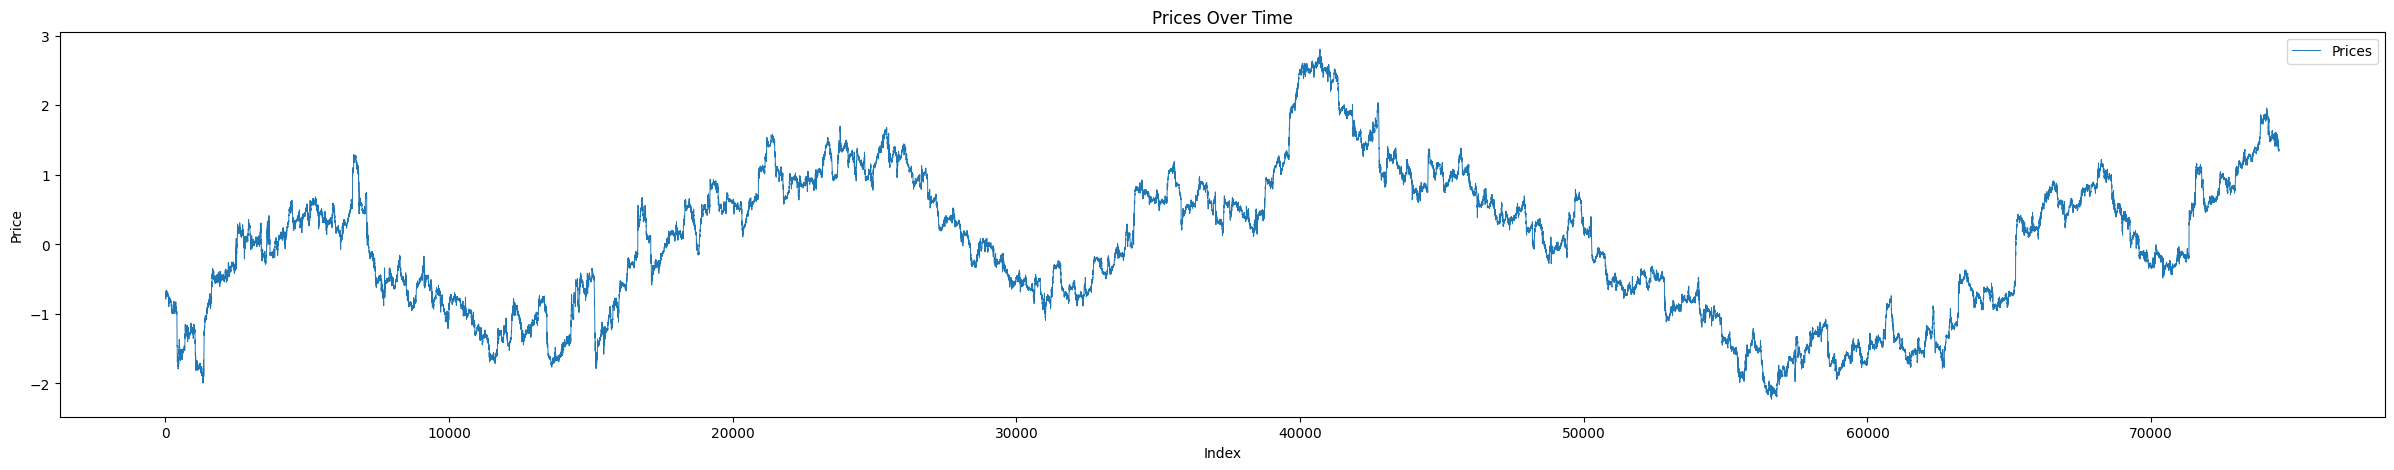

In [3]:
# df for absolute data
# df_standardized for standardized data

rate_value = df_standardized["open"].values
# rate_value = df['open'].values

# Create an array of indexes for the X axis
x = np.arange(len(rate_value))

# Create the chart
plt.figure(figsize=(30, 5))
plt.plot(x, rate_value, label="Prices", linewidth=0.7)
plt.title("Prices Over Time")
plt.xlabel("Index")
plt.ylabel("Price")
plt.legend()
plt.show()

### FFT Spectrum Visualization

This cell visualizes the Fast Fourier Transform (FFT) of the price data to analyze frequency components. The plot displays the magnitude of frequencies in the `rate_value` data, highlighting the primary frequencies that contribute to the signal.

- **FFT Calculation**: `F` represents the FFT result, and `freq` contains the corresponding frequencies.
- **Graph Details**: The spectrum is plotted with a red line, and the x-axis is limited to a small range around zero to focus on the main frequencies.
- **Highlighting Frequency Range**: Vertical lines and shading between `lowrange` and `highrange` emphasize the selected frequency range.

This visualization helps in identifying dominant frequencies in the price data, which can be crucial for analyzing cyclical patterns or noise.

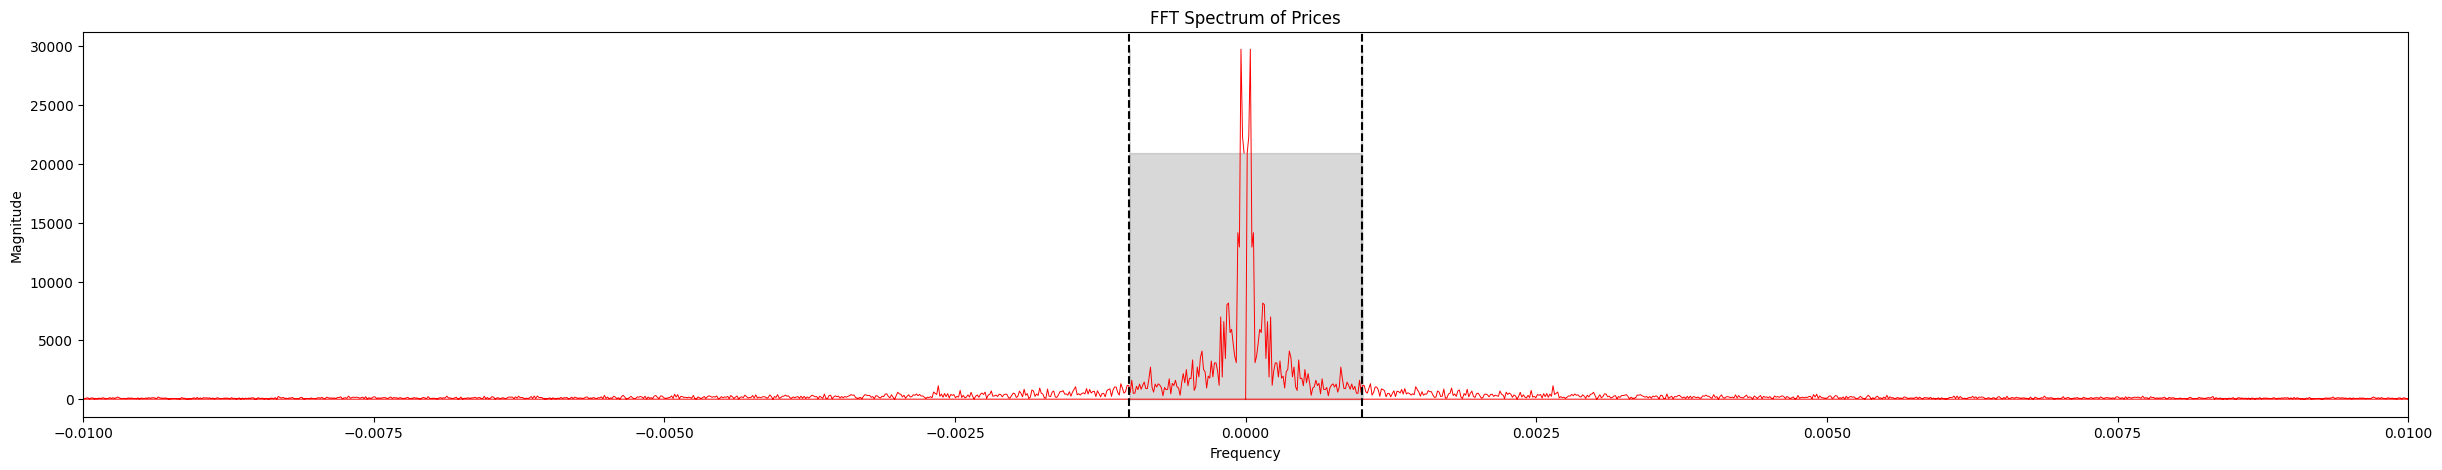

In [4]:
plt.rcParams["figure.dpi"] = 100  # DPI

# Compute FFT and Frequency and n
F = np.fft.fft(rate_value)
freq = np.fft.fftfreq(len(rate_value))
n = len(F)

# Frequency spectrum graph
plt.figure(figsize=(30, 5))
plt.plot(freq, np.abs(F), color="red", linewidth=0.7)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("FFT Spectrum of Prices")

# Zoom near the origin
plt.xlim([-0.010, 0.010])  # Adjust these values ​​according to your needs

# Marking the range selected
lowrange = -0.001
highrange = 0.001
plt.axvline(x=lowrange, color="k", linestyle="--")
plt.axvline(x=highrange, color="k", linestyle="--")
plt.fill_betweenx(np.abs(F), lowrange, highrange, color="grey", alpha=0.3)

plt.show()

### Frequency Filtering

This cell focuses on filtering the original signal within specific frequency ranges and visualizing the impact of this filtering:

- **Frequency Ranges**: Defined for filtering in `ranges`. These ranges are critical in isolating particular frequency components of interest.

- **Filtering Process**: For each defined frequency range, the original signal's frequency domain representation is copied and filtered to zero out components outside the range. The inverse FFT is then computed to translate back to the time domain.

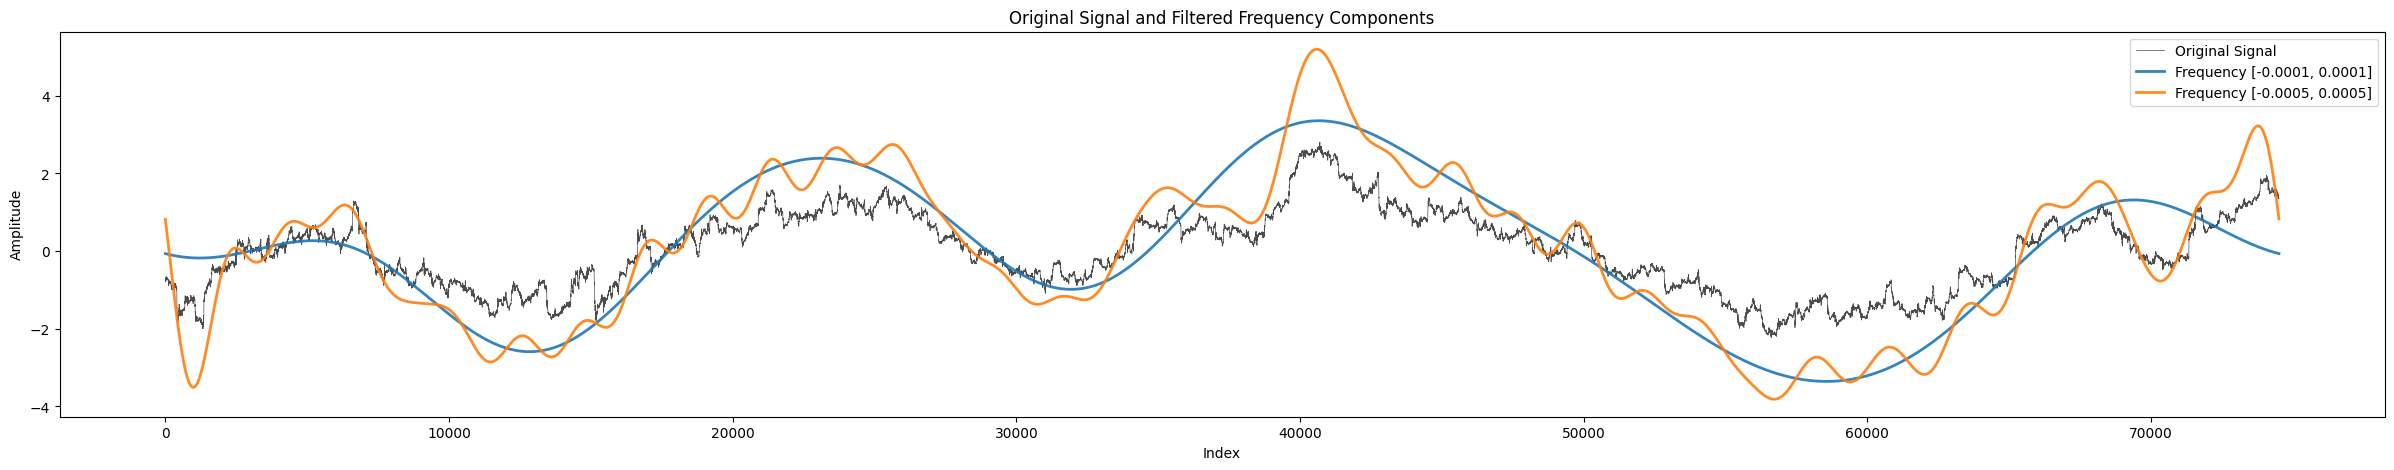

In [9]:
# Define frequency ranges to filter within
ranges = [(-0.0001, 0.0001), (-0.0005, 0.0005)]

# Initialize the plot with a specific size for clarity
plt.figure(figsize=(30, 5))

# Original signal and plot it
plt.plot(np.arange(n), rate_value, label="Original Signal", linewidth=0.5, alpha=0.7, color="black")

# Loop through each frequency range for filtering
for i, (f_min, f_max) in enumerate(ranges, start=1):
    # Create a copy of the original frequency domain signal
    F_filtered = np.copy(F)

    # Zero out frequencies outside the specified range to filter them
    F_filtered[(freq < f_min) | (freq > f_max)] = 0

    # Compute the inverse FFT of the filtered signal
    f_filtered = np.real(np.fft.ifft(F_filtered))

    # Apply a gain factor if necessary, based on the frequency range
    gain = 2 if (f_min, f_max) > (-10, 10) else 1

    # Plot the filtered signal with the applied gain
    plt.plot(
        np.arange(n),
        f_filtered * gain,
        label=f"Frequency [{f_min}, {f_max}]",
        alpha=0.9,
        linewidth=2,
    )

# Add title, labels, and legend to the plot for clarity and context
plt.title("Original Signal and Filtered Frequency Components")
plt.xlabel("Index")
plt.ylabel("Amplitude")
plt.legend()

# Display the plot
plt.show()

### Combining Filtered Frequency Components

In this cell, we explore the effects of combining multiple frequency-filtered components of the original signal:

- **Frequency Ranges**: We specify `ranges_to_combine` as our target ranges for filtering, aiming to isolate and combine specific frequency components.

- **Frequency Domain Filtering**: For each frequency range, we filter out components outside the range from the original signal's frequency domain representation. These filtered versions are then combined by addition, focusing on the cumulative effect.

- **Time Domain Conversion**: The combined frequency domain signal undergoes an inverse Fourier Transform, bringing it back to the time domain as `f_combined_filtered`.

This cell demonstrates the process and impact of selective frequency filtering and the combination of these filters on the original signal.

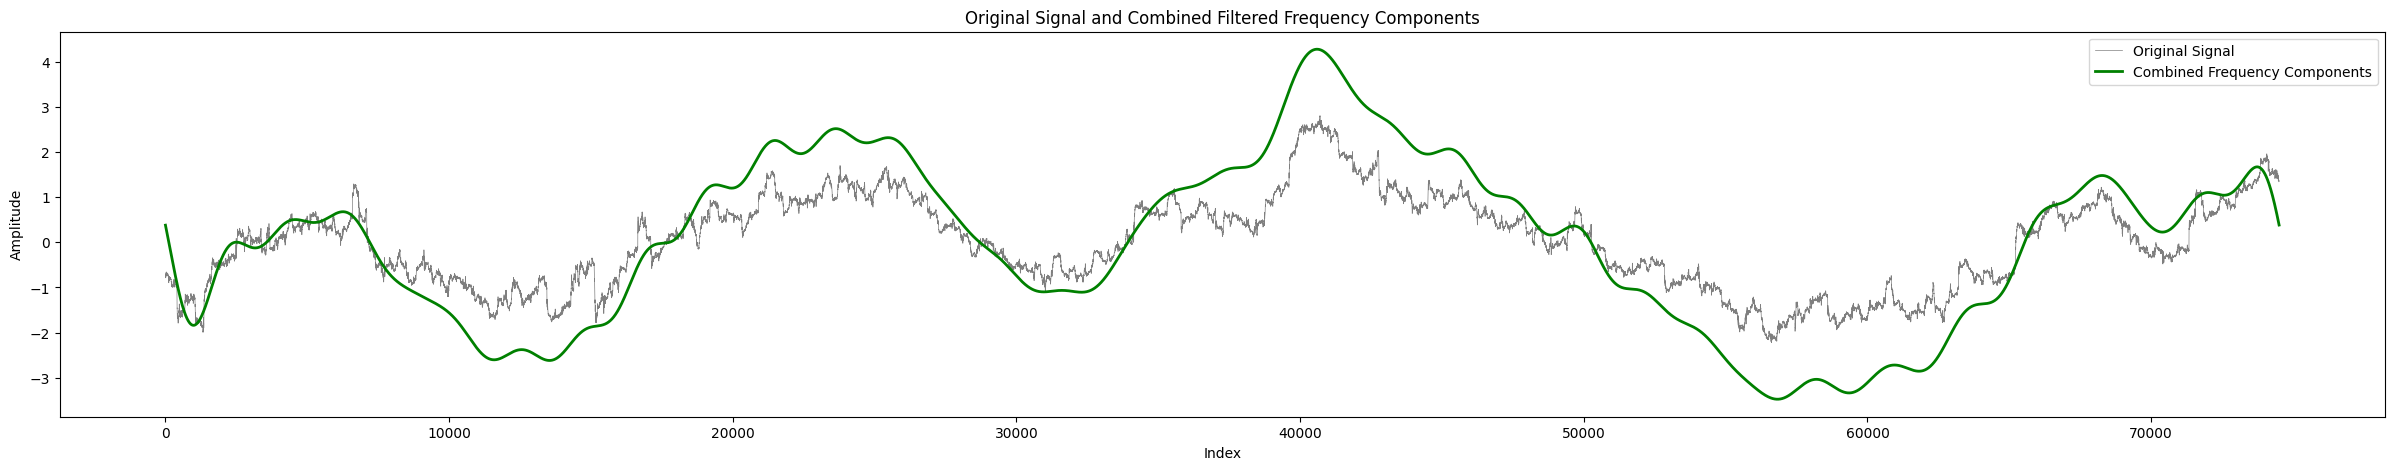

In [6]:
# Set the figure resolution
plt.rcParams["figure.dpi"] = 100

# Define frequency ranges to filter and combine
ranges_to_combine = [(-0.0001, 0.0001), (-0.0005, 0.0005)]

# Initialize the plot with a specified size for clarity
plt.figure(figsize=(30, 5))

# Plot the original signal
plt.plot(np.arange(n), rate_value, label="Original Signal", linewidth=0.5, alpha=0.5, color="black")

# Initialize a combined filtered signal in the frequency domain
F_combined_filtered = np.zeros_like(F)

# Loop through each frequency range to combine filtered components
for f_min, f_max in ranges_to_combine:
    # Copy F to apply filtering
    F_filtered = np.copy(F)

    # Apply filtering: zero out frequencies outside the specified range
    F_filtered[(freq < f_min) | (freq > f_max)] = 0

    # Combine filtered signals by adding them in the frequency domain
    F_combined_filtered += F_filtered

# Perform Inverse Fourier Transform to obtain the combined filtered signal in the time domain
f_combined_filtered = np.real(np.fft.ifft(F_combined_filtered))

# Plot the combined and potentially amplified signal
plt.plot(
    np.arange(n),
    f_combined_filtered,
    label="Combined Frequency Components",
    linewidth=2,
    color="green",
)

# Add title, labels, and legend to the plot for clarity and context
plt.title("Original Signal and Combined Filtered Frequency Components")
plt.xlabel("Index")
plt.ylabel("Amplitude")
plt.legend()

# Display the plot
plt.show()

### Trend Analysis in Filtered Signal

This cell visualizes trends within the filtered signal, highlighting upward and downward movements:

- **Original Signal**: Displayed as a black line for reference, providing context to the filtered signal's trends.
- **Trend Detection**: Iterates through the filtered signal to identify changes in direction. A positive difference indicates an upward trend, while a negative difference indicates a downward trend.
- **Trend Visualization**: 
  - Upward trends are marked with green lines, starting from the detected beginning of the trend until a change in direction is identified.
  - Downward trends are indicated with red lines, using the same logic.

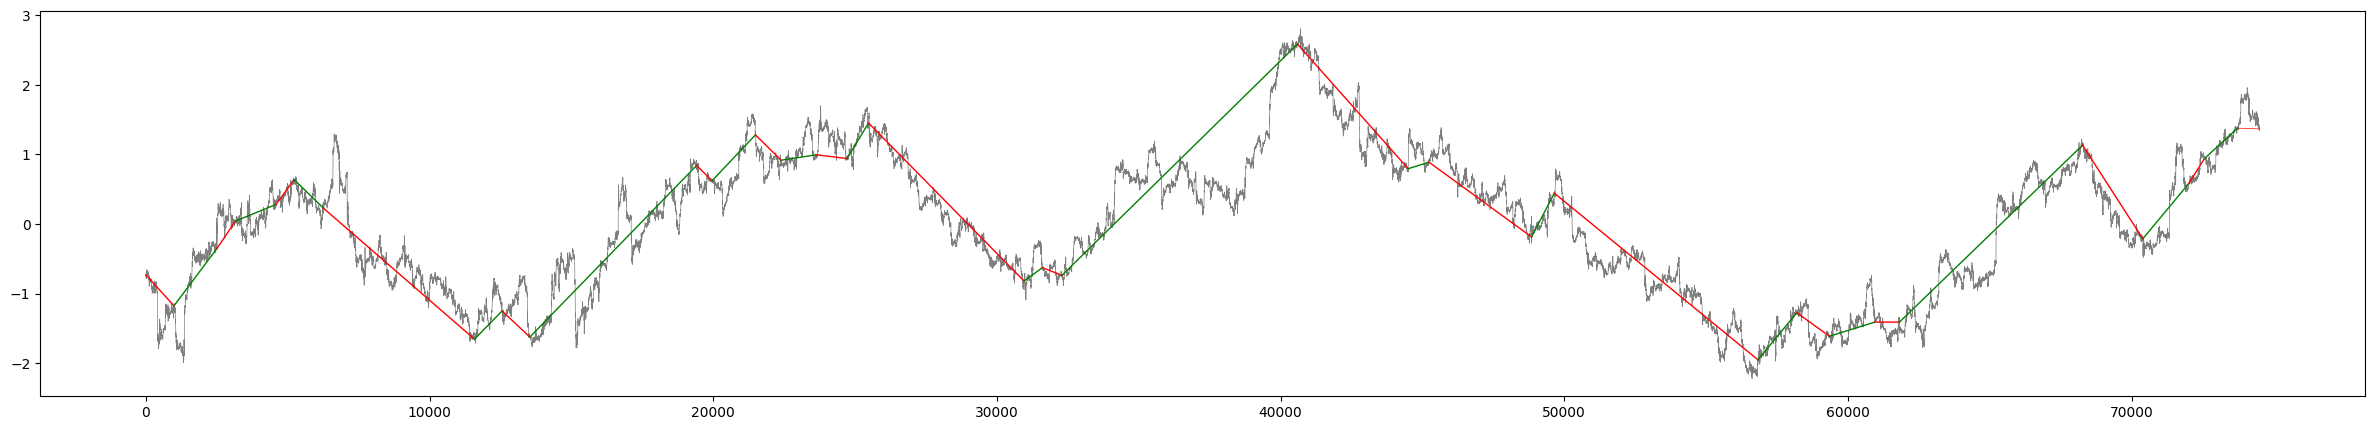

In [7]:
# Set the figure resolution
plt.rcParams["figure.dpi"] = 100

# Initialize variables to track the current trend and its starting point
current_position = None  # 'up', 'down', or None for no current trend
starting_point = None  # To store the start of the current trend

# Set up the plot with a specific size
plt.figure(figsize=(30, 5))

# Plot the original signal
plt.plot(np.arange(n), rate_value, label="Original Signal", linewidth=0.5, alpha=0.5, color="black")

# Iterate through the combined and filtered signal
for i in range(1, len(f_combined_filtered)):
    # Calculate the difference from the previous value to determine the trend
    difference = f_combined_filtered[i] - f_combined_filtered[i - 1]

    if difference > 0:  # Signal is trending upwards
        if current_position != "up":
            # If not previously 'up', close the current line and start a new one
            if starting_point is not None:  # Check if there's a line to close
                # Draw a red line from the starting point to the current point to indicate a downward trend
                plt.plot(
                    [starting_point, i - 1],
                    [rate_value[starting_point], rate_value[i - 1]],
                    "red",
                    linewidth=1,
                )
            starting_point = i - 1  # Set new starting point for an upward trend
            current_position = "up"
    elif difference < 0:  # Signal is trending downwards
        if current_position != "down":
            # If not previously 'down', close the current line and start a new one
            if starting_point is not None:  # Check if there's a line to close
                # Draw a green line from the starting point to the current point to indicate an upward trend
                plt.plot(
                    [starting_point, i - 1],
                    [rate_value[starting_point], rate_value[i - 1]],
                    "green",
                    linewidth=1,
                )
            starting_point = i - 1  # Set new starting point for a downward trend
            current_position = "down"

# Close the last line at the end of the dataset
if starting_point is not None and current_position == "up":
    # Draw a green line at the end to indicate the final upward trend
    plt.plot(
        [starting_point, len(rate_value) - 1],
        [rate_value[starting_point], rate_value[-1]],
        "green",
        linewidth=0.5,
    )
elif starting_point is not None and current_position == "down":
    # Draw a red line at the end to indicate the final downward trend
    plt.plot(
        [starting_point, len(rate_value) - 1],
        [rate_value[starting_point], rate_value[-1]],
        "red",
        linewidth=0.5,
    )

plt.show()